 # MVPA Factors


In [248]:
import numpy as np
import nibabel as nb
import os
from nilearn.input_data import NiftiMasker

In [249]:
# define paths
root_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2'
#fmriprep_dir = os.path.join(root_dir, 'derivatives', 'fmriprep23')
dataset_dir  = os.path.join(root_dir, 'derivatives', 'mvpa_05_factors_bold', 'features')

n_runs_per_sub = 4

In [250]:
# list datasets and concatenate

# find all *_dataset.nii.gz files in dataset_dir
dataset_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_features.npy') & f.startswith('sub-')]
dataset_files.sort()

# find all *_trial_types.txt files in dataset_dir
label_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_labels.npy') & f.startswith('sub-')]
label_files.sort()

In [251]:
# get number of subjects
n_subjects = len(dataset_files) / n_runs_per_sub
print('Number of subjects found: %d' % n_subjects)

Number of subjects found: 17


In [252]:
# concatenate all datasets in dataset_files
print('Concatenating datasets...')
D = np.concatenate([np.load(f) for f in dataset_files], axis=0)
print('Dataset shape: %s' % str(D.shape))

Concatenating datasets...
Dataset shape: (1224, 8)


In [253]:
# concatenate all labels into a single string array
print('Concatenating labels...')
labels = np.concatenate([np.load(f, allow_pickle=True) for f in label_files], axis=0)
print('Labels shape: %s' % str(labels.shape))

Concatenating labels...
Labels shape: (1224,)


In [254]:
samples = D

In [255]:
# generate an array of chunk labels
# 13 subjects, 9 x 2 music for each of the 4 runs
n_music_trials = 9*2
n_music_splits = 1
chunks = np.repeat(np.arange(1,n_subjects+1), 
                   n_music_trials*n_runs_per_sub*n_music_splits)

In [256]:
# Let's specify the classifier
from sklearn.svm import LinearSVC
clf = LinearSVC(multi_class="ovr", max_iter=1000, class_weight='balanced', dual='auto')
#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced')

## Manual Leave One Subject Out Cross Validation

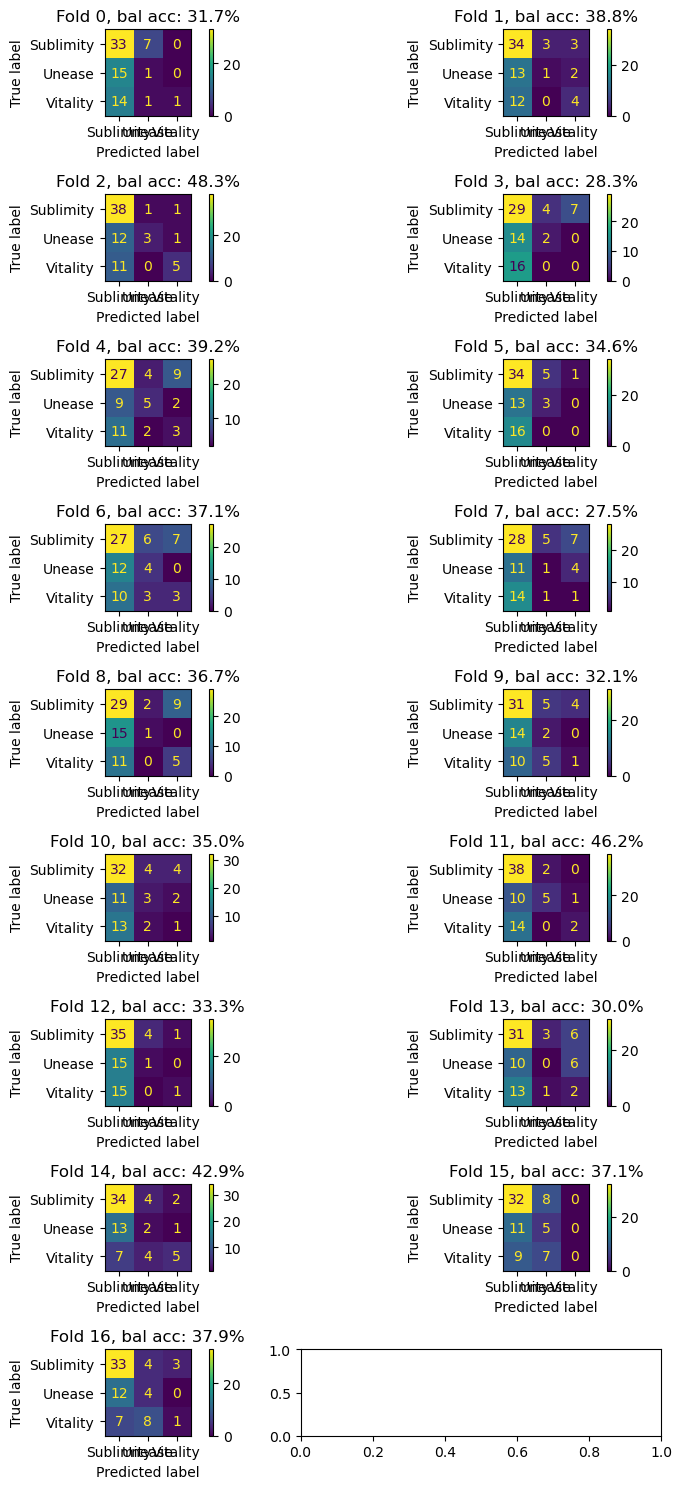

In [257]:
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

n_folds = int(n_subjects)
acc_array = np.zeros(n_folds)
acc_bal_array = np.zeros(n_folds)

fig, ax = plt.subplots(9, 2, figsize=(8, 15))

for ff in range(n_folds):
    # split the data into training and test set
    train_mask = chunks != ff+1
    test_mask = chunks == ff+1

    X_train = samples[train_mask, :]
    y_train = labels[train_mask]
    X_test = samples[test_mask, :]
    y_test = labels[test_mask]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute the prediction accuracy for the different labels
    acc_array[ff] = (y_pred == y_test).mean()
    acc_bal_array[ff] = balanced_accuracy_score(y_test, y_pred)

    # Confusion matrix plots
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax[ff // 2, ff % 2])
    ax[ff // 2, ff % 2].set_title(f"Fold {ff}, bal acc: {acc_bal_array[ff]*100:0.1f}%")

plt.tight_layout()


In [258]:
print(f"Mean accuracy: {acc_array.mean()*100:0.1f}% \u00B1 {acc_array.std()*100:0.1f}%")
print(f"Mean balanced accuracy: {acc_bal_array.mean()*100:0.1f}% \u00B1 {acc_bal_array.std()*100:0.1f}%")

Mean accuracy: 50.9% ± 5.8%
Mean balanced accuracy: 36.3% ± 5.6%


In [259]:
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, GridSearchCV
from sklearn.svm import SVC

clf = SVC(kernel='rbf', class_weight='balanced', max_iter=10000)
param_grid = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}
cv = LeaveOneGroupOut()
grid = GridSearchCV(clf, param_grid, cv=cv, n_jobs=6, scoring='balanced_accuracy')
grid.fit(samples, labels, groups=chunks)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")



/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anacond

Best parameters: {'C': 1000, 'gamma': 0.01}
Best score: 0.4247549019607843


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Text(0.5, 1.0, 'Balanced accuracy: 45.8%')

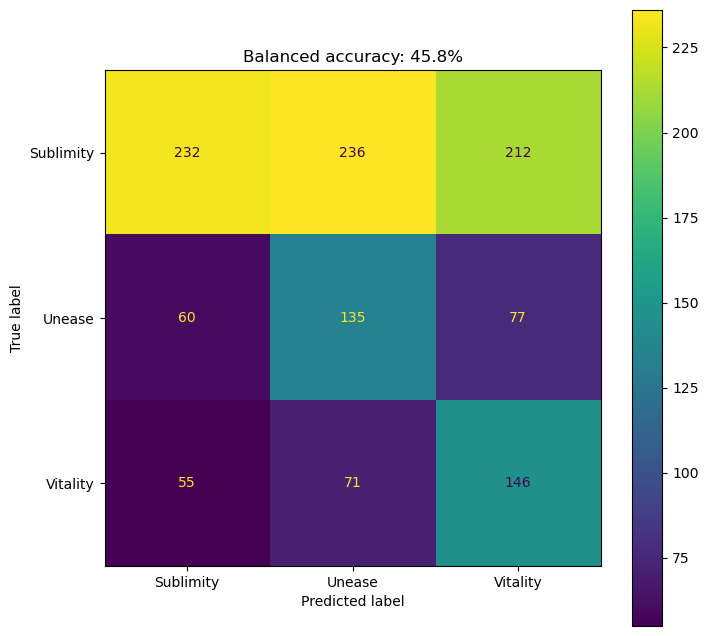

In [260]:
# plot the confusion matrix
clf = grid.best_estimator_
clf.fit(samples, labels)
y_pred = clf.predict(samples)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ConfusionMatrixDisplay.from_estimator(clf, samples, labels, ax=ax)
ax.set_title(f"Balanced accuracy: {balanced_accuracy_score(labels, y_pred)*100:0.1f}%")

In [1]:
clf

NameError: name 'clf' is not defined

In [261]:
clf = SVC(kernel='rbf', class_weight='balanced', max_iter=10000, C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])

cv_scores = cross_validate(estimator=clf,
                X=samples,
                y=labels,
                groups=chunks,
                cv=LeaveOneGroupOut(),
                n_jobs=6,
                return_train_score=True,
                return_estimator = True,
                verbose=1)

cv_scores['train_score'], cv_scores['test_score']

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  17 out of  17 | elapsed:    0.2s finished


(array([0.41579861, 0.42361111, 0.40277778, 0.41666667, 0.39930556,
        0.42621528, 0.421875  , 0.4296875 , 0.42447917, 0.41059028,
        0.41927083, 0.40798611, 0.42881944, 0.41666667, 0.42447917,
        0.41319444, 0.40885417]),
 array([0.40277778, 0.38888889, 0.54166667, 0.29166667, 0.45833333,
        0.375     , 0.34722222, 0.25      , 0.47222222, 0.36111111,
        0.44444444, 0.5       , 0.40277778, 0.19444444, 0.375     ,
        0.38888889, 0.44444444]))

In [262]:
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
clf = LinearSVC(multi_class="ovr", max_iter=1000, class_weight='balanced', dual='auto')

# search for better C
from sklearn.model_selection import GridSearchCV
param_grid = {'C': np.linspace(0.00001, 1000, 100)}
grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=6, scoring='balanced_accuracy')
grid_search.fit(samples, labels)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'C': 272.72728}
Best score: 0.38133539280733025


In [263]:
#clf = LinearSVC(multi_class="ovr", max_iter=1000, class_weight='balanced', dual='auto', C=grid_search.best_params_['C'])
#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(class_weight='balanced', max_iter=1000)
cv_scores = cross_validate(estimator=grid_search.best_estimator_,
                X=samples,
                y=labels,
                groups=chunks,
                cv=LeaveOneGroupOut(),
                n_jobs=6,
                return_train_score=True,
                return_estimator = True,
                verbose=1)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  17 out of  17 | elapsed:    0.0s finished


In [264]:
cv_scores['train_score'], cv_scores['test_score']

(array([0.52864583, 0.515625  , 0.51215278, 0.52517361, 0.51388889,
        0.52430556, 0.51041667, 0.52690972, 0.51736111, 0.52083333,
        0.51215278, 0.51388889, 0.51128472, 0.50868056, 0.51649306,
        0.52604167, 0.52083333]),
 array([0.5       , 0.51388889, 0.63888889, 0.41666667, 0.5       ,
        0.47222222, 0.47222222, 0.375     , 0.45833333, 0.48611111,
        0.44444444, 0.63888889, 0.51388889, 0.45833333, 0.51388889,
        0.51388889, 0.5       ]))

In [265]:
np.mean(cv_scores['test_score'])

0.49509803921568635